# Pattern recognition on wafer bin maps

In [35]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
import csv
import glob

In [4]:
df = pd.read_pickle("data/LSWMD.pkl")

In [5]:
df.head()

waferMap  dieSize lotName  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   

   waferIndex trianTestLabel failureType  
0         1.0   [[Training]]    [[none]]  
1         2.0   [[Training]]    [[none]]  
2         3.0   [[Training]]    [[none]]  
3         4.0   [[Training]]    [[none]]  
4         5.0   [[Training]]    [[none]]

In [6]:
df = df.drop(['waferIndex', 'trianTestLabel', 'lotName'], axis=1)

In [7]:
df['failureType'].apply(lambda x: str(x)).unique()

array(["[['none']]", "[['Loc']]", '[]', "[['Edge-Loc']]", "[['Center']]",
       "[['Edge-Ring']]", "[['Scratch']]", "[['Random']]",
       "[['Near-full']]", "[['Donut']]"], dtype=object)

It is necessary to make Kaggle dataset classes correspond with the company dataset. This is why some classes are merged:

clear = none

probe = edge-loc, edge-ring

field = loc, center, donut

mask = random, near-full

scratch = scratch

In [8]:
mapping = {'none': 'clear', 'Donut': 'field', 'Edge-Loc': 'probe', 'Edge-Ring': 'probe', 'Loc': 'field', 'Random': 'mask', 'Scratch': 'scratch', 'Near-full': 'mask', 'Center': 'field'}
df = df.replace({'failureType': mapping})

c:\programdata\miniconda3\lib\site-packages\pandas\core\array_algos\replace.py:84: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [9]:
mapping = {'clear': 0, 'probe':1, 'field':2, 'mask':3, 'scratch': 4}
df = df.replace({'failureType': mapping})

In [10]:
df['failureType'].apply(lambda x: str(x)).unique()

array(['0', '2', '[]', '1', '4', '3'], dtype=object)

There are too many defectless maps in comparison with maps with defects, and thus only some are selected for working dataset.

In [11]:
df_defect = df.loc[df['failureType'] > 0]
df_defect = df_defect.reset_index()
df_clean = df.loc[df['failureType']== 0]
df_clean = df_clean.reset_index()

In [12]:
df_clean_sample = df_clean.sample(5000)
df_defect = pd.concat([df_defect, df_clean_sample])
df_defect = df_defect.reset_index()
df_defect = df_defect.drop(['level_0'], axis=1)

### Different sizes of maps => resizing necessary
- upsampling with opencv

In [13]:
dimensions = []
for index, row in df_defect.iterrows():
    x_dim = len(df_defect.waferMap[index])
    y_dim = len(df_defect.waferMap[index][0])
    dimensions.append((x_dim, y_dim))
df_defect['dimensions'] = dimensions

In [14]:
max(df_defect.dimensions)

(212, 84)

In [15]:
upsampledMaps = []
for index, row in df_defect.iterrows():
    upsampled = cv2.resize(df_defect.waferMap[index], (212, 212))
    upsampledMaps.append(upsampled)
df_defect['upsampledMap'] = upsampledMaps

In [16]:
df_defect.drop(columns=['index'], axis=1)

waferMap  dieSize failureType  \
0      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0           2   
1      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2460.0           1   
2      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2460.0           1   
3      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2460.0           1   
4      [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2460.0           1   
...                                                  ...      ...         ...   
30514  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2,...    518.0           0   
30515  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1483.0           0   
30516  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    562.0           0   
30517  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1893.0           0   
30518  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    562.0           0   

      dimensions                                       upsampledMap  
0       (45, 48)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1       (53, 58)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2       (53, 58)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3       (53, 58)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4       (53, 58)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...          ...                                                ...  
30514   (27, 25)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
30515   (45, 42)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
30516   (29, 26)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
30517   (50, 49)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
30518   (29, 26)  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[30519 rows x 5 columns]

In [17]:
dimensions = []
for index, row in df_defect.iterrows():
    x_dim = len(df_defect.upsampledMap[index])
    y_dim = len(df_defect.upsampledMap[index][0])
    dimensions.append((x_dim, y_dim))
df_defect['dimensions'] = dimensions

### Model

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(212, 212, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation = 'softmax'))

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 210, 210, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 105, 105, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 128)      0

### Pretraining on Kaggle dataset
- dataset WM811k (https://www.kaggle.com/qingyi/wm811k-wafer-map)

In [21]:
# due to hardware limitations i cannot train the cnn on the full dataset, hence why i'm only selecting a sample here
df_sample = df_defect.sample(10000)
x = df_sample['upsampledMap'].tolist()
y = df_sample['failureType'].tolist()
x = np.array(x)
y = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42) 

In [22]:
# for training with the whole dataset
"""
x = df_defect['upsampledMap'].tolist()
y = df_defect['failureType'].tolist()
x = np.array(x)
y = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42) 
"""

"\nx = df_defect['upsampledMap'].tolist()\ny = df_defect['failureType'].tolist()\nx = np.array(x)\ny = to_categorical(y)\nx_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42) \n"

In [23]:
model.fit(x_train, y_train, epochs=2, validation_data=(x_test, y_test), batch_size=16)

Epoch 1/2
469/469 [==============================] - 511s 1s/step - loss: 0.7064 - accuracy: 0.7276 - val_loss: 0.4998 - val_accuracy: 0.8312
Epoch 2/2
469/469 [==============================] - 548s 1s/step - loss: 0.4077 - accuracy: 0.8547 - val_loss: 0.4589 - val_accuracy: 0.8480


In [24]:
test_loss, test_acc = model.evaluate(x_test, y_test)

79/79 [==============================] - 50s 625ms/step - loss: 0.4589 - accuracy: 0.8480


### Loading and preparation of company data
subfolder name equals label

#### Loading data

In [25]:
def load_folder(folder): # folder name equals defect type
    df = pd.DataFrame(columns = ['fileName', 'waferMap', 'originalLabel', 'upsampledMap'])
    path = 'data/sp/' + folder
    all_files = glob.glob(path + "/*.csv")
    i = 0
    
    for filename in all_files:
        filename = filename.replace('data/sp/' + folder + '\\', '')
        datafile = open('data/sp/' + folder + '/' + filename, 'r')
        data = list(csv.reader(datafile, delimiter=','))
        data.pop(0)
        for index in range(0, len(data)):
            data[index].pop(0)
        for k in range(0, len(data)):
            for j in range(0, len(data[0])):
                data[k][j]=np.uint8(float(data[k][j]) + 1) # + 1 necessary to save field relations when converting to uint8
        data = np.array(data, dtype=np.uint8)
        upsampled = cv2.resize(data, (212, 212))
        df.loc[i] = [filename, data, folder, upsampled]
        i += 1
    return df

In [26]:
df_comp = pd.DataFrame(columns = ['fileName', 'waferMap', 'originalLabel'])
folders = ['clear', 'field', 'mask', 'probe', 'scratch']
for folder in folders:
    new_df = load_folder(folder)
    df_comp = pd.concat([df_comp, new_df], ignore_index=True)
df_comp

c:\programdata\miniconda3\lib\site-packages\pandas\core\dtypes\cast.py:881: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


fileName                                           waferMap  \
0      10000_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1       1000_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2       1001_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3       1002_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4       1003_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                ...                                                ...   
14468   96_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14469   97_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14470   98_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14471   99_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14472    9_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

      originalLabel                                       upsampledMap  
0             clear  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1             clear  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2             clear  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3             clear  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4             clear  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...             ...                                                ...  
14468       scratch  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14469       scratch  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14470       scratch  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14471       scratch  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14472       scratch  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[14473 rows x 4 columns]

#### Data preprocessing
- resizing to 212 x 212
- mapping categories to numbers

In [27]:
mapping = {'clear': 0, 'probe': 1, 'field': 2, 'mask': 3, 'scratch': 4}
df_comp = df_comp.replace({'originalLabel': mapping})

In [28]:
df_comp

fileName                                           waferMap  \
0      10000_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1       1000_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2       1001_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3       1002_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4       1003_clear.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
...                ...                                                ...   
14468   96_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14469   97_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14470   98_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14471   99_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
14472    9_scratch.csv  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

       originalLabel                                       upsampledMap  
0                  0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1                  0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2                  0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3                  0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4                  0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...              ...                                                ...  
14468              4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14469              4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14470              4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14471              4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
14472              4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[14473 rows x 4 columns]

In [29]:
dim = []
for index, row in df_comp.iterrows():
    x_dim = len(df_comp.upsampledMap[index])
    y_dim = len(df_comp.upsampledMap[index][0])
    dim.append((x_dim, y_dim))
df_comp['dimensions'] = dim

### Transfer learning

In [30]:
# convolutional base from previously trained CNN
conv_base = keras.models.Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_2').output)
conv_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 212, 212, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 210, 210, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 105, 105, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 51, 51, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 49, 49, 128)       73856 

In [31]:
def feature_extraction(xext, yext):
    features = conv_base.predict(xext, batch_size = 16)
    return features, yext

In [32]:
def transfer_learning(xft, yft, xfv, yfv):
    print("Transfer learning")
    # feature extraction
    train_features, train_labels = feature_extraction(xft, yft)
    val_features, val_labels = feature_extraction(xfv, yfv)
    print("Features extracted")
    print(train_features[0].shape)
    print(val_features[0].shape)
    train_features = np.reshape(train_features, (len(train_features), 24* 24* 128 ))
    val_features = np.reshape(val_features, (len(val_features), 24* 24* 128 ))
    # dense classificator
    model2 = models.Sequential()
    model2.add(layers.Flatten())
    model2.add(layers.Dense(256, activation='relu', input_dim=24* 24* 128))
    model2.add(layers.Dropout(0.5))
    model2.add(layers.Dense(5, activation='softmax'))
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Compiled")
    history = model2.fit(train_features, train_labels, epochs=5, 
                         validation_data=(val_features, val_labels), batch_size=16)
    print("Fitted")  
    
    return history, model2

### K-fold cross-validation

In [34]:
def predict_classes(x, model):
    pfeatures = conv_base.predict(x, batch_size = 16)
    pfeatures = np.reshape(pfeatures, (len(pfeatures), 24* 24* 128 ))
    predictions = model.predict(pfeatures, batch_size = 16)
    return np.argmax(predictions, axis=1).tolist()

In [44]:
def kfold(xc_train, yc_train, xc_test, yc_test):
    histories = []
    kf_models = []
    class_reports = []
    k_folds = 9
    kf = KFold(k_folds).split(xc_train, yc_train)

    for n, (train_index, val_index) in enumerate(kf):
        xc = xc_train[train_index, :]
        yc = yc_train[train_index]
        xc_val = xc_train[val_index, :]
        yc_val = yc_train[val_index]

        # transfer learning part
        history, new_model = transfer_learning(xc, yc, xc_val, yc_val)
        histories.append(history)
        kf_models.append(new_model)
        
        # PRECISION/RECALL/F1
        y_predicted = predict_classes(xc_test, new_model)
        class_report = metrics.classification_report(np.argmax(yc_test, axis=1).tolist(), y_predicted, digits=3)
        class_reports.append(class_report)
        print(class_report)
    return histories, kf_models, class_reports

#### Splitting data and training

In [32]:
"""
xc = df_comp['upsampledMap'].tolist()
yc = df_comp['originalLabel'].tolist()
xc = np.array(xc)
yc = to_categorical(yc)
xc_train, xc_test, yc_train, yc_test = train_test_split(xc, yc, random_state=42)
histories, kf_models, class_reports = kfold(xc_train, yc_train)
"""

"\nxc = df_comp['upsampledMap'].tolist()\nyc = df_comp['originalLabel'].tolist()\nxc = np.array(xc)\nyc = to_categorical(yc)\nxc_train, xc_test, yc_train, yc_test = train_test_split(xc, yc, random_state=42)\nhistories, kf_models = kfold(xc_train, yc_train)\n"

In [45]:
# SAMPLE
df_sam = df_comp.sample(5000)
xc = df_sam['upsampledMap'].tolist()
yc = df_sam['originalLabel'].tolist()
xc = np.array(xc)
yc = to_categorical(yc)
xc_train, xc_test, yc_train, yc_test = train_test_split(xc, yc, random_state=42) 
histories2, kf_models2, class_reports2 = kfold(xc_train, yc_train, xc_test, yc_test)

Transfer learning
Features extracted
(24, 24, 128)
(24, 24, 128)
Compiled
Epoch 1/5
209/209 [==============================] - 33s 137ms/step - loss: 0.3716 - accuracy: 0.9172 - val_loss: 0.1375 - val_accuracy: 0.9520
Epoch 2/5
209/209 [==============================] - 28s 132ms/step - loss: 0.1208 - accuracy: 0.9658 - val_loss: 0.1382 - val_accuracy: 0.9640
Epoch 3/5
209/209 [==============================] - 29s 139ms/step - loss: 0.0831 - accuracy: 0.9721 - val_loss: 0.1717 - val_accuracy: 0.9568
Epoch 4/5
209/209 [==============================] - 28s 132ms/step - loss: 0.0633 - accuracy: 0.9823 - val_loss: 0.2418 - val_accuracy: 0.9616
Epoch 5/5
209/209 [==============================] - 28s 133ms/step - loss: 0.0666 - accuracy: 0.9835 - val_loss: 0.2578 - val_accuracy: 0.9496
Fitted
              precision    recall  f1-score   support

           0      0.972     0.998     0.985       869
           1      0.843     0.641     0.728        92
           2      0.947     0.878   

c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.981     0.992     0.986       869
           1      0.840     0.685     0.754        92
           2      0.949     0.902     0.925        41
           3      0.930     0.992     0.960       241
           4      0.000     0.000     0.000         7

    accuracy                          0.961      1250
   macro avg      0.740     0.714     0.725      1250
weighted avg      0.954     0.961     0.957      1250

Transfer learning
Features extracted
(24, 24, 128)
(24, 24, 128)
Compiled
Epoch 1/5
209/209 [==============================] - 32s 135ms/step - loss: 0.3204 - accuracy: 0.9235 - val_loss: 0.2060 - val_accuracy: 0.9472
Epoch 2/5
209/209 [==============================] - 27s 128ms/step - loss: 0.1280 - accuracy: 0.9634 - val_loss: 0.2275 - val_accuracy: 0.9472
Epoch 3/5
209/209 [==============================] - 27s 128ms/step - loss: 0.0921 - accuracy: 0.9727 - val_loss: 0.2470 - val_accuracy: 0.9472
Epoch

c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.972     0.994     0.983       869
           1      0.795     0.674     0.729        92
           2      0.941     0.780     0.853        41
           3      0.948     0.979     0.963       241
           4      0.000     0.000     0.000         7

    accuracy                          0.955      1250
   macro avg      0.731     0.686     0.706      1250
weighted avg      0.948     0.955     0.951      1250

Transfer learning
Features extracted
(24, 24, 128)
(24, 24, 128)
Compiled
Epoch 1/5
209/209 [==============================] - 48s 142ms/step - loss: 0.3702 - accuracy: 0.9166 - val_loss: 0.1813 - val_accuracy: 0.9496
Epoch 2/5
209/209 [==============================] - 28s 132ms/step - loss: 0.1299 - accuracy: 0.9637 - val_loss: 0.2240 - val_accuracy: 0.9353
Epoch 3/5
209/209 [==============================] - 26s 126ms/step - loss: 0.0860 - accuracy: 0.9775 - val_loss: 0.2874 - val_accuracy: 0.9376
Epoch

#### Results

In [56]:
def choose_best(histories, kf_models, class_reports2):
    # compare validation accuracies of newely made models and choose the best
    best_acc_index = 0
    best_acc = 0
    for index, history in enumerate(histories):
        if history.history['val_accuracy'][-1] > best_acc:
            best_acc_index = index
            best_acc = history.history['val_accuracy'][-1]
    return kf_models[best_acc_index], histories[best_acc_index], class_reports2[best_acc_index]

In [57]:
chosen_model, best_history, report = choose_best(histories2, kf_models2, class_reports2)

In [48]:
print(best_history.history)

{'loss': [0.347962349653244, 0.13173964619636536, 0.08818725496530533, 0.060973796993494034, 0.06554224342107773], 'accuracy': [0.914791464805603, 0.9651964902877808, 0.9750975370407104, 0.983198344707489, 0.9864986538887024], 'val_loss': [0.18857035040855408, 0.2105831801891327, 0.21726004779338837, 0.2347724586725235, 0.2907421290874481], 'val_accuracy': [0.9520383477210999, 0.9544364213943481, 0.9568345546722412, 0.9568345546722412, 0.9592326283454895]}


In [58]:
print(report)
# 'scratch' defect is barely present in this sample, training with the whole dataset would likely yield different results,
# though due to hardware limitations, i am unable to do that

              precision    recall  f1-score   support

           0      0.990     0.988     0.989       869
           1      0.778     0.837     0.806        92
           2      0.946     0.854     0.897        41
           3      0.955     0.971     0.963       241
           4      0.000     0.000     0.000         7

    accuracy                          0.964      1250
   macro avg      0.734     0.730     0.731      1250
weighted avg      0.960     0.964     0.962      1250



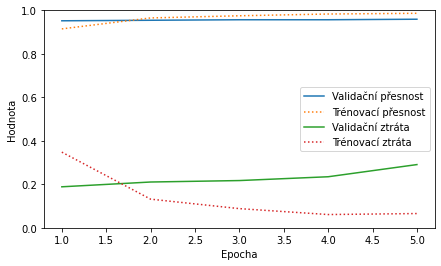

In [49]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,4))
ax = plt.gca()
x = [1, 2, 3, 4, 5]
ax.set_ylim([0, 1])
plt.xlabel("Epocha")
plt.ylabel("Hodnota")
plt.plot(x, best_history.history['val_accuracy'], label= 'Validační přesnost')
plt.plot(x, best_history.history['accuracy'], label= 'Trénovací přesnost', linestyle=":")
plt.plot(x, best_history.history['val_loss'], label= 'Validační ztráta')
plt.plot(x, best_history.history['loss'], label= 'Trénovací ztráta', linestyle=":")
plt.legend()
plt.show()

#### Test resulting model

In [50]:
def evaluate_model(chosen_model, x_test, y_test):
    # that twice trained model evaluate with test dataset
    pfeatures = conv_base.predict(x_test, batch_size = 16)
    pfeatures = np.reshape(pfeatures, (len(pfeatures), 24* 24* 128 ))
    return chosen_model.evaluate(pfeatures, y_test, batch_size = 16)

In [51]:
evaluation = evaluate_model(chosen_model, xc_test, yc_test)

79/79 [==============================] - 6s 53ms/step - loss: 0.1948 - accuracy: 0.9640


### Predict labels of company data

In [61]:
# predict labels with new model on company data
number_of_samples = 50
df_sam = df_comp.sample(number_of_samples, ignore_index=True)
x_to_predict = np.array(df_sam['upsampledMap'].tolist())
pfeatures = conv_base.predict(x_to_predict, batch_size = 16)
pfeatures = np.reshape(pfeatures, (len(pfeatures), 24* 24* 128 ))
predictions = chosen_model.predict(pfeatures, batch_size = 16)
predictions_classes= np.argmax(predictions, axis=1).tolist()

### Save predictions into a DataFrame

In [62]:
result = df_sam[['fileName']].copy()
result['prediction'] = predictions_classes
is_defect = [] # 0 == no defect, 1 == defect
for index, row in result.iterrows():
    if result.prediction[index] == 0:
        is_defect.append(0)
    else:
        is_defect.append(1)
result['isDefect'] = is_defect
mapping = {0: 'clear', 1: 'probe', 2: 'field', 3: 'mask', 4: 'scratch'}
result = result.replace({'prediction': mapping})
result.head()

fileName prediction  isDefect
0  1398_clear.csv      clear         0
1   2683_mask.csv       mask         1
2   328_clear.csv      clear         0
3  5940_clear.csv      clear         0
4  1023_clear.csv      clear         0

### Multilabel prediction

In [63]:
limit = 0.01 # predictions with value over this limit are taken as being present in that map
multilabel_predictions = []
for prediction in predictions:
    labels = []
    for index, value in enumerate(prediction):
        if value > limit:
            labels.append(mapping[index])
    multilabel_predictions.append(labels)
result['multilabelPrediction'] = multilabel_predictions

In [64]:
is_defect = [] # 0 == no defect, 1 == defect
for index, row in result.iterrows():
    if result.multilabelPrediction[index] == ['clear']:
        is_defect.append(0)
    else:
        is_defect.append(1)
result['isDefectMultilabel'] = is_defect

In [65]:
result

fileName prediction  isDefect  multilabelPrediction  \
0   1398_clear.csv      clear         0               [clear]   
1    2683_mask.csv       mask         1                [mask]   
2    328_clear.csv      clear         0               [clear]   
3   5940_clear.csv      clear         0               [clear]   
4   1023_clear.csv      clear         0               [clear]   
5   2487_clear.csv      clear         0               [clear]   
6     982_mask.csv       mask         1  [clear, probe, mask]   
7   6991_clear.csv      clear         0               [clear]   
8   2243_clear.csv      clear         0        [clear, probe]   
9   1975_clear.csv      clear         0               [clear]   
10  1629_clear.csv      clear         0        [clear, probe]   
11   325_clear.csv      clear         0               [clear]   
12  8126_clear.csv      clear         0        [clear, probe]   
13      9_mask.csv       mask         1         [probe, mask]   
14  4296_clear.csv      clear         0               [clear]   
15    488_mask.csv       mask         1                [mask]   
16  9607_clear.csv      clear         0               [clear]   
17  2949_clear.csv      clear         0               [clear]   
18  4099_clear.csv      clear         0               [clear]   
19  9800_clear.csv      clear         0               [clear]   
20  2382_clear.csv      clear         0               [clear]   
21  7935_clear.csv      clear         0               [clear]   
22  5120_clear.csv      clear         0               [clear]   
23   2034_mask.csv       mask         1                [mask]   
24  5267_clear.csv      clear         0               [clear]   
25  9333_clear.csv      clear         0               [clear]   
26  3917_clear.csv      clear         0               [clear]   
27  8485_clear.csv      clear         0               [clear]   
28  4636_clear.csv      clear         0               [clear]   
29  4160_clear.csv      clear         0               [clear]   
30  1584_clear.csv      clear         0        [clear, probe]   
31  6679_clear.csv      clear         0               [clear]   
32   1581_mask.csv       mask         1                [mask]   
33  3984_clear.csv      clear         0               [clear]   
34   991_probe.csv      probe         1               [probe]   
35  8527_clear.csv      clear         0               [clear]   
36  4020_clear.csv      clear         0               [clear]   
37   602_clear.csv      clear         0               [clear]   
38  2506_clear.csv      clear         0        [clear, probe]   
39  2266_clear.csv      clear         0               [clear]   
40    19_clear.csv      clear         0        [clear, probe]   
41   943_clear.csv      clear         0               [clear]   
42   232_probe.csv      probe         1        [clear, probe]   
43  9902_clear.csv      clear         0               [clear]   
44  8570_clear.csv      clear         0               [clear]   
45  7513_clear.csv      clear         0               [clear]   
46    293_mask.csv       mask         1                [mask]   
47  5513_clear.csv      clear         0               [clear]   
48   277_probe.csv      probe         1               [probe]   
49  5072_clear.csv      clear         0        [clear, probe]   

    isDefectMultilabel  
0                    0  
1                    1  
2                    0  
3                    0  
4                    0  
5                    0  
6                    1  
7                    0  
8                    1  
9                    0  
10                   1  
11                   0  
12                   1  
13                   1  
14                   0  
15                   1  
16                   0  
17                   0  
18                   0  
19                   0  
20                   0  
21                   0  
22                   0  
23                   1  
24                   0  
25                   0  
26                 

In [66]:
pred = result.to_csv('prediction.csv')